# Прогноз связей в динамической сети соавторов

Networkx - основная библиотека для работы с сетями

In [1]:
import json, os, re
import pandas as pd
import networkx as nx
from itertools import combinations

import matplotlib.pyplot as plt
from scipy import sparse

Получение списока имен файлов, содержащих данные журналов НХ

In [2]:
path_to_json = 'geofix'
json_files = [pos_json for pos_json in os.listdir(path_to_json)]

In [3]:
# Функции для очистки имен от доп. информации

def flatten(l):
    return [item for sublist in l for item in sublist]

def cleanNames(names_list):
    expr = '[А-ЯЁ]\.[А-ЯЁ]\. [А-ЯЁ][а-яё]*|[А-ЯЁ][а-яё]* [А-ЯЁ]\.[А-ЯЁ]\.'
    filt_list = []
    for name in names_list:
        filt_list.append([x for x in re.findall(expr, name) if x != []])
    filt_list2 = []
    for l in flatten(filt_list):
        x1, x2 = l.split(' ')
        if x1.count('.') == 2:
            filt_list2.append(l)
        else:
            filt_list2.append(' '.join([x2,x1]))
    return filt_list2

Считывание данных в датафрейм pandas из файлов json

In [4]:
df = pd.DataFrame(columns=['authors_raw', 'year', 'geo', 'geo_full'])

for index, js in enumerate(json_files):
    with open(os.path.join('geofix', js)) as json_file:
        json_text = json.load(json_file)
        
        authors = json_text['authors_cleaned']
        year = json_text['year']
        geo = json_text['geo_tags']
        geo_full = json_text['geo_tags_full']
        df.loc[index] = [authors, year, geo, geo_full]
        
df['authors'] = df['authors_raw'].apply(cleanNames)
df['year'] = df['year'].astype(int)
df.head()

authors_raw  year  \
0                  [Д.Г. Нероденко, К.В. Сызранцева]  2012   
1                                     [Н.Н. Иванцов]  2012   
2  [И.В. Гончаров, Н.В. Обласов, А.В. Сметанин, В...  2012   
3                                    [В.Ю. Овечкина]  2012   
4                        [Д.В. Ефимов, К.Е. Шлычков]  2012   

                                                 geo  \
0  {'K.V. Syzrantseva': 'Tyumen State Oil and Gas...   
1          {'N.N. Ivantsov': 'TNNC LLC, RF, Tyumen'}   
2  {'S.V. Fadeeva': 'TomskNIPIneft JSC, RF, Tomsk...   
3            {'T.V. Olneva': 'Paradigm, RF, Moscow'}   
4     {'V.I. Savichev': 'BashNIPIneft LLC, RF, Ufa'}   

                                            geo_full  \
0  {'d.g. nerodenko': nan, 'k.v. syzrantseva': 'T...   
1          {'n.n. ivantsov': 'TNNC LLC, RF, Tyumen'}   
2  {'i.v. goncharov': nan, 'n.v. oblasov': nan, '...   
3  {'v.yu. ovechkina': nan, 't.v. olneva': 'Parad...   
4  {'d.v. efimov': nan, 'k.e. shlychkov': nan, 'v...   

                                             authors  
0                  [Д.Г. Нероденко, К.В. Сызранцева]  
1                                     [Н.Н. Иванцов]  
2  [И.В. Гончаров, Н.В. Обласов, А.В. Сметанин, В...  
3                                    [В.Ю. Овечкина]  
4                        [Д.В. Ефимов, К.Е. Шлычков]

Функция для создания сети соавторства

In [5]:
def createGraph(frame):
    G = nx.Graph()
    for i, row in frame.iterrows():
        authors = list(row['geo_full'].items())
        
        year = row['year']
        if len(authors) == 1:
            G.add_node(authors[0][0], geo = authors[0][1])
        else:
            for auth1, auth2 in combinations(authors, 2):
                try:
                    geo1 = auth1[1].split(',')[-1].lstrip()
                except AttributeError:
                    geo1 = 'None'
                try:
                    geo2 = auth2[1].split(',')[-1].lstrip()
                except AttributeError:
                    geo2 = 'None'
                    
                G.add_node(auth1[0], geo=geo1)
                G.add_node(auth2[0], geo=geo2)
                G.add_edge(auth1[0], auth2[0], year=year)
    return G

Создание тренировочного и тестового графа

In [6]:
train = df[(df['year'] >= 2012) & (df['year'] <= 2014)]
train_graph = createGraph(train)
train_authors = set(train_graph.nodes)

test = df[df['year'] == 2016]
test_graph = createGraph(test)
test_authors = set(test_graph.nodes)

In [7]:
# самая большая связная компонента
comp1 = [c for c in sorted(nx.connected_component_subgraphs(train_graph), key=len, reverse=True)][0]

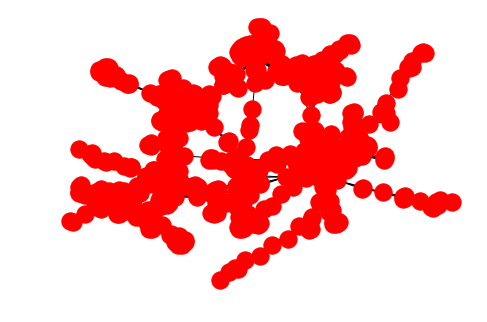

In [8]:
nx.draw_spring(comp1)

In [9]:
#Авторы, которые присутствуют и в train и в test
common_authors = train_authors.intersection(test_authors)

In [10]:
# Создаем матрицу с количеством общих соседей для каждой вершины в графе
def commonNeighbors(Graph):
    n = Graph.number_of_nodes()
    d = sparse.lil_matrix((n,n), dtype=int)
    
    for i1, n1 in enumerate(Graph.nodes):
        for i2, n2 in enumerate(Graph.nodes):
            if n1 != n2:
                d[i2,i1] = len(list(nx.common_neighbors(Graph, n1, n2)))
    return d

Предсказание на основе колличества общих соседей

In [11]:
# матрица с количеством общих соседей между узлами графов
common_neighbors = commonNeighbors(train_graph)
# то же, только с именами (датафрэйм)
df_train_sim = pd.DataFrame(common_neighbors.todense(), columns=train_graph.nodes, index=train_graph.nodes)
# то же, только для авторов из обоих наборов (train - test)
df_train_sim_ca = df_train_sim.loc[common_authors, common_authors]

In [12]:
#матрица смежности для тестового набора
test_adj = nx.adjacency_matrix(test_graph).todense()
# то же, только с именами
df_test_adj = pd.DataFrame(test_adj, columns=test_graph.nodes, index=test_graph.nodes)
# то же, только для авторов из обоих наборов (train - test)
df_test_adj_ca = df_test_adj.loc[common_authors, common_authors]

In [13]:
#Сколько должно быть общих соседей чтобы сказать что между вершинами будет связь?
threshold = 4
#Матрица смежности для связей которые могут быть в будущем
mask = (df_train_sim_ca > threshold).astype(int)

Расчет точности предсказания

In [14]:
#сколько ребер предсказано верно
tp = (mask.values & df_test_adj_ca.as_matrix()).sum()

#сколько всего предсказанных ребер
pred = mask.sum().sum()

#точность предсказания связей графа
precision = tp / pred
print (precision)

0.4125


In [15]:
Gmask = nx.from_numpy_matrix(mask.values)

In [16]:
# самая большая связная компонента
comp1_mask = [c for c in sorted(nx.connected_component_subgraphs(Gmask), key=len, reverse=True)][0]

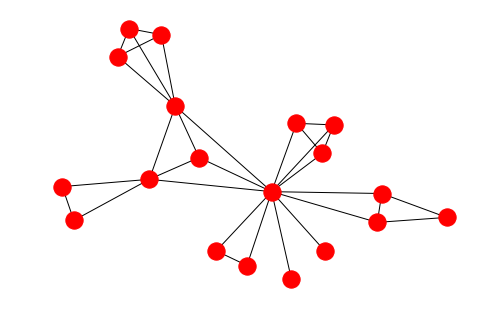

In [17]:
nx.draw_spring(comp1_mask)

Пользовательское решение


In [72]:
print(len(df[(df['year'] == 2012)]))
print(len(df[(df['year'] == 2013)]))
print(len(df[(df['year'] == 2014)]))
print(len(df[(df['year'] == 2016)]))

266
163
191
302


In [73]:
train = df[(df['year'] == 2012) | (df['year'] == 2013) | (df['year'] == 2016)]
train_graph = createGraph(train)
train_authors = set(train_graph.nodes)

test = df[df['year'] == 2014]
test_graph = createGraph(test)
test_authors = set(test_graph.nodes)

#Авторы, которые присутствуют и в train и в test
common_authors = train_authors.intersection(test_authors)

In [74]:
common_neighbors = commonNeighbors(train_graph)

In [80]:
#Пользовательская
# то же, только с именами (датафрэйм)
df_train_sim = pd.DataFrame(common_neighbors.todense(), columns=train_graph.nodes, index=train_graph.nodes)
# то же, только для авторов из обоих наборов (train - test)
df_train_sim_ca = df_train_sim.loc[common_authors, common_authors]

#матрица смежности для тестового набора
test_adj = nx.adjacency_matrix(test_graph).todense()
# то же, только с именами
df_test_adj = pd.DataFrame(test_adj, columns=test_graph.nodes, index=test_graph.nodes)
# то же, только для авторов из обоих наборов (train - test)
df_test_adj_ca = df_test_adj.loc[common_authors, common_authors]


#Сколько должно быть общих соседей чтобы сказать что между вершинами будет связь?
threshold = 3
#Матрица смежности для связей которые могут быть в будущем
mask = (df_train_sim_ca > threshold).astype(int)
#сколько ребер предсказано верно
tp = (mask.values & df_test_adj_ca.as_matrix()).sum()

#сколько всего предсказанных ребер
pred = mask.sum().sum()

#точность предсказания связей графа
precision = tp / pred
print (precision)
print("верно предсказано ", tp)
print("сколько всего предсказанных ребер ", pred)


0.524886877828
верно предсказано  232
сколько всего предсказанных ребер  442


In [ ]:
#против
#0.4125
#верно предсказано  132
#сколько всего предсказанных ребер  320

Прогноз связей для журналов 2015 года и выгрузка в формате gml

In [81]:
df5 = pd.read_csv('nodes_2015.csv')
valid_authors = set(df5['0'])

In [82]:
#Авторы, которые присутствуют и в train и в valid
common_authors = train_authors.intersection(valid_authors)
df_train_sim_ca = df_train_sim.loc[common_authors, common_authors]

In [83]:
#Матрица смежности для связей которые могут быть в будущем
mask = (df_train_sim_ca > threshold).astype(int)

In [84]:
Gmask5 = nx.from_numpy_array(mask.values)
Gmask5 = nx.relabel_nodes(Gmask5, dict(enumerate(common_authors)))
nx.write_gml(Gmask5, 'edges_2015.gml')